In [1]:
from IPython.display import display, HTML

video_path = 'office.MOV'

video_html = f"""
<video controls>
    <source src="{video_path}" type="video/mp4">
</video>
"""

display(HTML(video_html))


In [2]:

import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time, warnings
from datetime import datetime #DB
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.backend               import set_session
from tensorflow.keras                       import backend #, models
from tensorflow.keras.models                import load_model
from tensorflow.keras.utils                 import plot_model #DB

import gc #DB
from config import fcn_config as cfg
from config import fcn8_cnn as cnn

warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.visible_device_list = "0"
set_session(tf.compat.v1.Session(config=config))




fcn_config.py runs from  /workspace/Vitis-AI-Tutorials-2.5/Tutorials/Keras_FCN8_UNET_segmentation/files/code


In [3]:

HEIGHT = cfg.HEIGHT
WIDTH  = cfg.WIDTH
N_CLASSES = cfg.NUM_CLASSES
EPOCHS = cfg.EPOCHS
UPSCALE=False

dir_data = cfg.DATASET_DIR
dir_train_img = cfg.dir_train_img
dir_train_seg = cfg.dir_train_seg
dir_test_img  = cfg.dir_test_img
dir_test_seg  = cfg.dir_test_seg
dir_calib_img = cfg.dir_calib_img
dir_calib_seg = cfg.dir_calib_seg
dir_valid_img = cfg.dir_valid_img
dir_valid_seg = cfg.dir_valid_seg

######################################################################
# model
######################################################################

#model = UNET((HEIGHT, WIDTH, 3))

model = cnn.FCN8(nClasses     = N_CLASSES,
             input_height = HEIGHT,
             input_width  = WIDTH,
                 upscale = UPSCALE)


######################################################################
# prepare testing and validation data
######################################################################

# load validation images
valid_images = os.listdir(dir_valid_img)
valid_images.sort()
valid_segmentations  = os.listdir(dir_valid_seg)
valid_segmentations.sort()
X_valid = []
Y_valid = []
for im , seg in zip(valid_images,valid_segmentations) :
    X_valid.append( cnn.NormalizeImageArr(os.path.join(dir_valid_img, im)) )
    Y_valid.append( cnn.LoadSegmentationArr( os.path.join(dir_valid_seg, seg), N_CLASSES , WIDTH, HEIGHT)  )
X_valid, Y_valid = np.array(X_valid) , np.array(Y_valid)
print("\n")
print("validation data (X) (Y) shapes:", X_valid.shape,Y_valid.shape)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


validation data (X) (Y) shapes: (0,) (0,)


In [4]:
test_images = os.listdir(dir_test_img)
test_images.sort()
test_segmentations  = os.listdir(dir_test_seg)
test_segmentations.sort()
X_test = []
Y_test = []
for im , seg in zip(test_images,test_segmentations) :
    X_test.append( cnn.NormalizeImageArr(os.path.join(dir_test_img,im)) )
    Y_test.append( cnn.LoadSegmentationArr(os.path.join(dir_test_seg, seg), N_CLASSES , WIDTH, HEIGHT)  )
X_test, Y_test = np.array(X_test) , np.array(Y_test)
print("testing    data (X) (Y) shapes", X_test.shape,Y_test.shape)
print("\n")

#########################################################################################################
# Calculate intersection over union for each segmentation class

if UPSCALE==False :
    model_filename= "../keras_model/fcn8/ep"    + str(EPOCHS) + "_trained_fcn8_"    + str(WIDTH) + "x" + str(HEIGHT) + ".hdf5"
else :
    model_filename= "../keras_model/fcn8ups/ep" + str(EPOCHS) + "_trained_fcn8ups_" + str(WIDTH) + "x" + str(HEIGHT) + ".hdf5"

model = load_model(model_filename) #DB

print("\nnow computing IoU over testing data set:")
y_pred1   = model.predict(X_test)
y_pred1_i = np.argmax(y_pred1, axis=3)
y_test1_i = np.argmax(Y_test, axis=3)
#print(y_test1_i.shape,y_pred1_i.shape)

np.save("ref_y_pred.npy",   y_pred1)
np.save("ref_y_pred_i.npy", y_pred1_i)
np.save("ref_y_test.npy",   Y_test)
np.save("ref_y_test_i.npy", y_test1_i)

cnn.IoU(y_test1_i, y_pred1_i)

print("\nnow computing IoU over validation data set:")
y_pred2 = model.predict(X_valid)
y_pred2_i = np.argmax(y_pred2, axis=3)
y_test2_i = np.argmax(Y_valid, axis=3)
#print(y_test2_i.shape,y_pred2_i.shape)
cnn.IoU(y_test2_i,y_pred2_i)


testing    data (X) (Y) shapes (0,) (0,)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

now computing IoU over testing data set:


ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (0, 1)

In [ ]:
image_path='/workspace/Vitis-AI-Tutorials-2.5/Tutorials/Keras_FCN8_UNET_segmentation/files/code/testing_0.png'

In [ ]:
img2=cv2.imread(image_path,1)

In [ ]:
plt.imshow(img2)

In [ ]:
def give_color_to_seg_img(seg,n_classes):
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    #colors = sns.color_palette("hls", n_classes) #DB
    colors = cfg.COLORS #DB
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0]))
        seg_img[:,:,1] += (segc*( colors[c][1]))
        seg_img[:,:,2] += (segc*( colors[c][2]))

    return(seg_img)


In [ ]:
img = cv2.resize(img2, (cfg.WIDTH, cfg.HEIGHT))
img = img.astype(np.float32)
img = img/cfg.NORM_FACTOR - 1.0
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
norm_test_img=np.array(img)
norm_test_img = np.reshape(norm_test_img, (1, 224, 224, 3))
y_pred1   = model.predict(norm_test_img)

In [ ]:
y_pred1.shape

In [5]:
y_pred1

NameError: name 'y_pred1' is not defined

In [6]:
y_pred1_i = np.argmax(y_pred1, axis=3)
y_pred1_i=np.reshape(y_pred1_i,(224,224))
final_img=give_color_to_seg_img(y_pred1_i,5)
plt.imshow(final_img/255)

NameError: name 'y_pred1' is not defined

In [22]:
y_pred1_i.shape

(224, 224)

In [5]:
def detect_img(img2):
    img = cv2.resize(img2, (cfg.WIDTH, cfg.HEIGHT))
    img = img.astype(np.float32)
    img = img/cfg.NORM_FACTOR - 1.0
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    norm_test_img=np.array(img)
    norm_test_img = np.reshape(norm_test_img, (1, 224, 224, 3))
    y_pred1   = model.predict(norm_test_img)
    y_pred1_i = np.argmax(y_pred1, axis=3)
    y_pred1_i=np.reshape(y_pred1_i,(224,224))
    final_img=give_color_to_seg_img(y_pred1_i,5)
    plt.imshow(final_img/255)
    return final_img

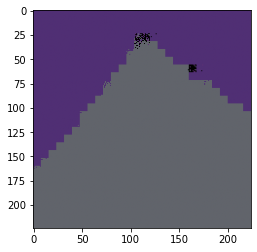

In [10]:
final_img=detect_img(img)

In [11]:
print(final_img)

[[[ 80.  47. 116.]
  [ 80.  47. 116.]
  [ 80.  47. 116.]
  ...
  [ 80.  47. 116.]
  [ 80.  47. 116.]
  [ 80.  47. 116.]]

 [[ 80.  47. 116.]
  [ 80.  47. 116.]
  [ 80.  47. 116.]
  ...
  [ 80.  47. 116.]
  [ 80.  47. 116.]
  [ 80.  47. 116.]]

 [[ 80.  47. 116.]
  [ 80.  47. 116.]
  [ 80.  47. 116.]
  ...
  [ 80.  47. 116.]
  [ 80.  47. 116.]
  [ 80.  47. 116.]]

 ...

 [[ 97. 100. 107.]
  [ 97. 100. 107.]
  [ 97. 100. 107.]
  ...
  [ 97. 100. 107.]
  [ 97. 100. 107.]
  [ 97. 100. 107.]]

 [[ 97. 100. 107.]
  [ 97. 100. 107.]
  [ 97. 100. 107.]
  ...
  [ 97. 100. 107.]
  [ 97. 100. 107.]
  [ 97. 100. 107.]]

 [[ 97. 100. 107.]
  [ 97. 100. 107.]
  [ 97. 100. 107.]
  ...
  [ 97. 100. 107.]
  [ 97. 100. 107.]
  [ 97. 100. 107.]]]


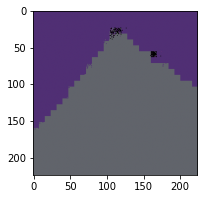

In [12]:
fig = plt.figure(figsize=(10,30))
ax = fig.add_subplot(1,3,1)
ax.imshow(final_img/255.0)

In [13]:
norm_test_img=cnn.NormalizeImageArr(image_path)
norm_test_img=np.array(norm_test_img)
norm_test_img = np.reshape(norm_test_img, (1, 224, 224, 3))
y_pred1   = model.predict(norm_test_img)
y_pred1_i = np.argmax(y_pred1, axis=3)
y_pred1_i=np.reshape(y_pred1_i,(224,224))

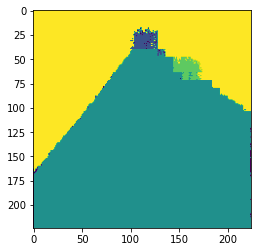

In [14]:
plt.imshow(y_pred1_i)

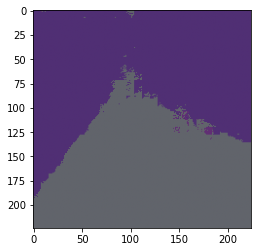

In [15]:

# Input and output video paths
input_video_path = 'office.MOV'
output_video_path = 'output_video.mp4'

# Open the input video file
input_video = cv2.VideoCapture(input_video_path)

# Get the video properties
frame_width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(input_video.get(cv2.CAP_PROP_FPS))

# Create a VideoWriter object to save the modified video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_video_path, fourcc, fps, (224, 224))

# Process each frame in the input video
while True:
    # Read the next frame
    ret, frame = input_video.read()
    if not ret:
        break
    rotated_frame = cv2.rotate(frame, cv2.ROTATE_180)
    frame=detect_img(rotated_frame)
    frame = frame.astype(np.uint8)
    # Write the modified frame to the output video
    output_video.write(frame)
a
# Release the input and output video objects
input_video.release()
output_video.release()
